### Tutorial content

This tutorial will focuse on how to process the data collection from [SNAP](https://snap.stanford.edu/data/#email), by using the graph data structure from [networkx](https://networkx.github.io) and apply the shi malik cut implemented in [scikit-lear](http://scikit-learn.org/stable/)

I will first give a small graph for illustration, and then apply the algorithm on the undirected and unweighted [facebook data](https://snap.stanford.edu/data/egonets-Facebook.html) downloaded from SNAP.

This tutorial will cover the following topics:
- [Installing the libraries](#Installing-the-libraries)
- [Normalized cut](#Normalized-cut)
- [Small graph illustration](#Small-graph-illustration)
- [Hierarchical Clustering ](#Hierarchical-Clustering )
- [Loading and preprocessing data ](#Loading-and-preprocessing-data )
- [Partition](#Partition)
- [Performance measurement](#Performance-measurement)
- [Summary and references](#Summary-and-references)

### Installing the libraries

Install networkx using `pip`: 

        $ pip install networkx
   
Install scikit-learn:

    If you have installed numpy and scipy, you can install through pip:  
         
         $ pip install -U scikit-learn
        
    or conda:
    
         $ conda install scikit-learn
        
    If not, you can first install [numpy](https://docs.scipy.org/doc/numpy-1.13.0/user/install.html) and [scipy](https://www.scipy.org/install.html)

In [1]:
import networkx as nx
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np

### Normalized cut
[Shi Malik cut](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.160.2324) proposed the ***normalized cut*** as a criterio for making a good partition: 
$$Ncut(A,B) = \frac{cut(A,B)}{assoc(A,V)} + \frac{cut(A,B)}{assoc(B,V)}$$
where $assoc(A,V) = \sum_{u \in A, t \in V}w(u,t)$ is the total connection from nodes in A to all nodes in the graph. cut(A,B) is the total number of edges that are removed to split graph V into graph A and B. The [SpectralClustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) from scikit learn can help us to perform this bipartition.

Before using the dataset from SNAP, I will walk through a small graph to illustrate how spectral clustering algorithm works.


### Small graph illustration
The graph, s, consists of 10 nodes with 17 edges connected. Note that we need to create a connected graph for a normalized cut. Then, we use networkx library to create the graph s. The methods draw_networkx_nodes add nodes to the graph, draw_networkx_labels labels each node with its node position value, and draw_networkx_edges adds the edges to the graph. 

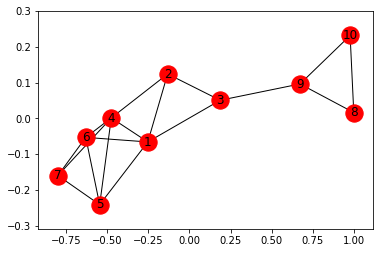

In [2]:
nodes = list(range(1,11))
edges = [(1,2), (2,3), (1,3), (1,4), (1,5), (1,6),(2,4), (4,5), (5,6), (6,7), (4,6), (4,7), (5,7), (3,9),(8,9), (9,10), (8,10)]
s = nx.Graph()
s.add_edges_from(edges)
s.pos = nx.spring_layout(s)
nx.draw_networkx_nodes(s, pos = s.pos)
nx.draw_networkx_labels(s, pos = s.pos)
nx.draw_networkx_edges(s, pos = s.pos)

To performe a minimized cut on the given graph above, it's clear that we will remove the edge (3,9). Let's apply normalized cut from scikit-learn to see how this splitting algorithm works. 

We first need to get adjacency matrix of the graph. After we call spectral_clustering, we can find the nodes corresponding in each cluster.

We define the function ***get_colormap*** that takes in the labels returned from spectral_clustering, and g as the graph that has just been clustered. This function will assign different colors for two clusters, and store the colors assigned in color_map. Note that where() return the index of the node, so we do node-1 to match the index. 

In [3]:
from sklearn.cluster import spectral_clustering

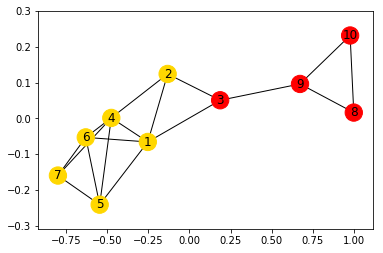

In [7]:
adjs = nx.adjacency_matrix(s)
labels = spectral_clustering(affinity = adjs, n_clusters = 2)

def get_colormap(labels, g, color_list = ['red', 'gold', 'green']):
    l = []
    for i in range(len(np.unique(labels))):
        l.append((np.where(labels == np.unique(labels)[i])[0]).tolist())
    color_map = []
    for node in g.nodes():
        for i in range(len(l)):
            if node-1 in l[i]:
                color_map.append(color_list[i])
    return color_map,l
color_map,l = get_colormap(labels, s)
nx.draw_networkx_nodes(s, pos = s.pos, node_color = color_map)
nx.draw_networkx_labels(s, pos = s.pos)
nx.draw_networkx_edges(s, pos = s.pos)            

With the color_map, we can visualize the culstered graph with no edges removed above. 
Notice that normalized cut does not give us the most optmized partition. Instead, it removes two edges and return two clusters with nodes (3,8,9,10) and (1,2,4,5,6,7). 

The following function Ncut(A,B,V) caculate $$Ncut(A,B) = \frac{cut(A,B)}{assoc(A,V)} + \frac{cut(A,B)}{assoc(B,V)}$$
A,B are the nodes in each cluster. Similarly, as mentioned above. A,B is the index for the node, so there is -1 difference between the node in edgelist(V) and node in A or B.

The optimized Ncut is 0.3214 compared to the actual 0.4871.

In [8]:
def Ncut(A,B, V):
    cut_A_B = 0.0
    asso_A_v = 0.0
    asso_B_v = 0.0
    for (i, j) in V:
        if((i-1 in A and j-1 in B) or (i - 1 in B and j-1 in A)):
            cut_A_B += 1
        if((i-1 in A) or (j-1 in A)):
            asso_A_v+= 1
        if((i-1 in B) or (j-1 in B)):
            asso_B_v+= 1
    print(asso_B_v, asso_A_v, cut_A_B)
    return cut_A_B/asso_A_v + cut_A_B/asso_B_v
Ncut(l[0], l[1], s.edges())

(13.0, 6.0, 2.0)


0.48717948717948717

### Hierarchical Clustering 
After one run of the partition, we have two subgraphs. If we want more clusters, we can do another run of normalized cut based on the hierarchical algorithm. The second partition will be applied on the larger graph(larger number of nodes). From the visualization above, we know that the yellow cluster gives larger graph. 
We can apply the previous partition code again here, and visualize the subgraph after second partition. 


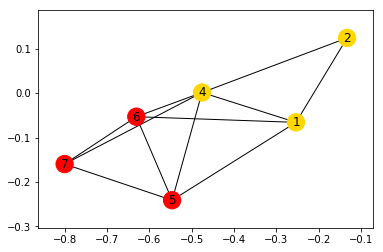

In [11]:
ed2 = []
for (i, j) in s.edges:
    if(i-1 in l[1] and j-1 in l[1]):
        ed2.append((i,j))
s2 = nx.Graph()
s2.add_edges_from(ed2)
adjs2 = nx.adjacency_matrix(s2)
labels2 = spectral_clustering(affinity = adjs2, n_clusters = 2)
color_map2,l2 = get_colormap(labels2, s)
nx.draw_networkx_nodes(s2, pos = s.pos, node_color = color_map2)
nx.draw_networkx_labels(s2, pos = s.pos)
nx.draw_networkx_edges(s2, pos = s.pos)       

The intuition behind hierarchical clustering is that if we want to get k clusters use normalized cut, we can recursively using the above method for k-1 times. 

### Loading and preprocessing data 

Download [facebook data](https://snap.stanford.edu/data/egonets-Facebook.html) from SNAP, and unzip the file and name the folder facebook.

Notice that there are more than edges and nodes information downloaded from snap. We will concentrate on the edges and nodes that help to construct our networkx graph object, which we assume here to be a unweighted and undirected graph.
In the facebook dataset, each node represents a person and the edge that connected two nodes shows two persons are friend. For the rest part of tutorial, we will use normalized cut to find social circles. 

You can load data using following command:

In [12]:
path = 'facebook'
efnames = [path + '/' + f for f in os.listdir(path) if 'edges' in f]
g = nx.Graph()
for efname in efnames:
    ELdf = pd.read_csv(efname,sep=' ',header=None)
    eliter = ELdf.iterrows()
    for e in eliter:
        g.add_edge(*tuple(e[1]))

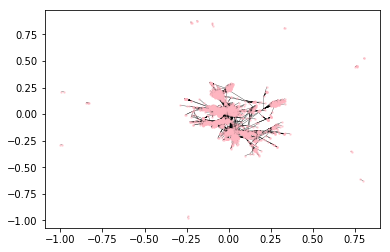

In [13]:
g.pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos = g.pos, node_color = "lightpink", node_size = 2, alpha = 0.5)
nx.draw_networkx_edges(g, pos = g.pos, width = 0.3)

Notice that we have many disconnected nodes or graphs in g. However, we only apply our normalized spectral clustering on a connected graph, so we need to select the biggest graph as g1.

There is no actual true position for each nodes, since it is an undirected graph. However, for the sake of visualization, we add certain position on the graph to get the each node in the same position. 
***Note***: for the following graph visualizations, we concentrate on how closely the nodes in each cluster(with different colors) connected trough edges, but not how closely the distances between nodes in each cluster.

In [14]:
graphs = list(nx.connected_component_subgraphs(g))
graphs.sort(key = lambda x : x.number_of_nodes(), reverse = True)

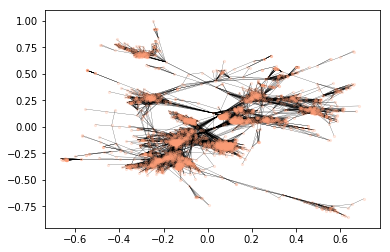

In [15]:
g1 = graphs[0]
g1.pos = nx.spring_layout(g1)
nx.draw_networkx_nodes(g1, pos = g1.pos, node_color = "lightsalmon", node_size = 5, alpha = 0.2)
nx.draw_networkx_edges(g1, pos = g1.pos, width = 0.2)

### Partition
The explaination for the following codes  refer to [Small graph illustration](#Small-graph-illustration)

In [16]:
adj = nx.adjacency_matrix(g1)
labels = spectral_clustering(affinity = adj, n_clusters = 2)
l1 = np.where(labels == 1)[0]
l0 = np.where(labels == 0)[0]
l = [l0.tolist(), l1.tolist()]

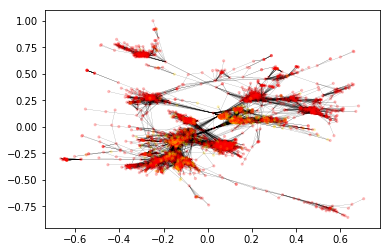

In [17]:
color_map = []
for node in g1.nodes():
    if node-1 in l[0]:
        color_map.append('red')
    if node-1 in l[1]: 
        color_map.append('gold')

nx.draw_networkx_nodes(g1, pos = g1.pos, node_color = color_map, node_size = 5, alpha = 0.2)
nx.draw_networkx_edges(g1, pos = g1.pos, width = 0.1)                  

The above graph, is the original graph without any edges removed.
As a comparision, we will remove the edges that connect the nodes from one cluster to the other. 

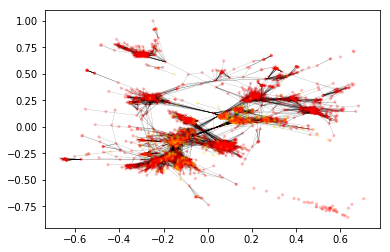

In [18]:
ed = g1.edges()
ed_removed0 = []
ed_removed1 = []
for (i, j) in ed:
    if(i-1 in l[0] and j-1 in l[0]):
        ed_removed0.append((i, j))
    if(i-1 in l[1] and j-1 in l[1]):
        ed_removed1.append((i, j))
a = []
a.extend(ed_removed0)
a.extend(ed_removed1)
nx.draw_networkx_nodes(g1, pos = g1.pos, node_color = color_map, node_size = 5, alpha = 0.2)
nx.draw_networkx_edges(g1, pos = g1.pos, edgelist = a, width = 0.1)

In fact, it's really hard to tell the difference, since there is the uneven number of nodes in each cluster. Therefore, we will just pull out only one cluster each time to check whether each cluster is highly connected.

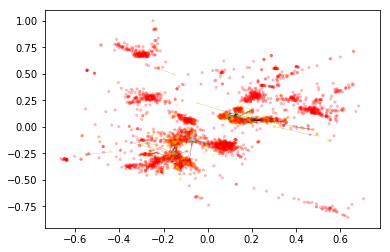

In [19]:
nx.draw_networkx_nodes(g1, pos = g1.pos, node_color = color_map, node_size = 5, alpha = 0.2)
nx.draw_networkx_edges(g1, pos = g1.pos, edgelist = ed_removed1, width = 0.1)

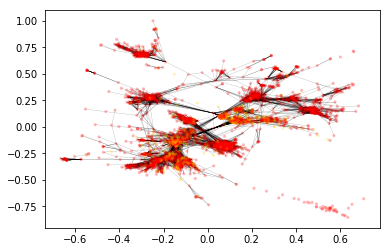

In [20]:
nx.draw_networkx_nodes(g1, pos = g1.pos, node_color = color_map, node_size = 5, alpha = 0.2)
nx.draw_networkx_edges(g1, pos = g1.pos, edgelist = ed_removed0, width = 0.1)

### Performance measurement
According to Shi Malik cut, we look for smaller value of the Ncut() to find out the how well we did for a minimized cut, the edges that have been removed. 

In [21]:
Ncut(l[0], l[1], g1.edges())

(36288.0, 75968.0, 28220.0)


1.149139747321438

### Summary and references

This tutorial focuse on applying Shi Malik cut on a undirected and unweighted graph based on spectral graph theory. However, there is some limitation on this application. For example, the overall tutorial can only be applied on the datastes that has no weights on edges and no directed relationship between nodes. Furthermore, Shi Malik cut is a bipartition method. If we want to get more than two clusters, we may consider hierarchical method combined with Shi Malik cut. Or, we can use other method like k-means clustering that could will return k clusters in one run.

This tutorial follows the format of [gis_tutorial](https://nbviewer.jupyter.org/url/www.datasciencecourse.org/tutorial/gis_tutorial.ipynb)  

For those curious minds:

- A [tutorial](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=7FE9EECAA344592C531E4731AB468E96?doi=10.1.1.165.9323&rep=rep1&type=pdf) on spectral clustering;
- Another [tutorial](http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf) on spectral clustering;
- some other related spectral clustering methods:
    [Kmeans spectral clustering](https://arxiv.org/abs/1205.0309),
    [Hierarchical spectral clustering](http://www.stat.cmu.edu/~siva/Papers/Spectral11.pdf )
    